In [18]:
import pickle
import pathlib

import numpy as np
import pandas as pd

In [19]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)
clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'
with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

c:\Users\Pedro Antônio Silva\Desktop\Semestre 4\Machine Learning\proj_1\ames\data


In [20]:
model_data = data.copy()
categorical_columns = []
ordinal_columns = []
for col in model_data.select_dtypes('category').columns:
    if model_data[col].cat.ordered:
        ordinal_columns.append(col)
    else:
        categorical_columns.append(col)
for col in ordinal_columns:
    codes, _ = pd.factorize(data[col], sort=True)
    model_data[col] = codes
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data, drop_first=True)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()
model_data = pd.get_dummies(model_data, drop_first=True)
model_data.info()
for cat in categorical_columns:
    dummies = []
    for col in model_data.columns:
        if col.startswith(cat + "_"):
            dummies.append(f'"{col}"')
    dummies_str = ', '.join(dummies)
    print(f'From column "{cat}" we made {dummies_str}\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2877 entries, 0 to 2929
Columns: 166 entries, Lot.Frontage to Exterior_Other
dtypes: bool(2), float64(34), int64(12), uint8(118)
memory usage: 1.4 MB
From column "MS.SubClass" we made "MS.SubClass_30", "MS.SubClass_50", "MS.SubClass_60", "MS.SubClass_70", "MS.SubClass_80", "MS.SubClass_85", "MS.SubClass_90", "MS.SubClass_120", "MS.SubClass_160", "MS.SubClass_190", "MS.SubClass_Other"

From column "MS.Zoning" we made "MS.Zoning_RH", "MS.Zoning_RL", "MS.Zoning_RM"

From column "Land.Contour" we made "Land.Contour_HLS", "Land.Contour_Low", "Land.Contour_Lvl"

From column "Lot.Config" we made "Lot.Config_CulDSac", "Lot.Config_FR2", "Lot.Config_FR3", "Lot.Config_Inside"

From column "Neighborhood" we made "Neighborhood_BrDale", "Neighborhood_BrkSide", "Neighborhood_ClearCr", "Neighborhood_CollgCr", "Neighborhood_Crawfor", "Neighborhood_Edwards", "Neighborhood_Gilbert", "Neighborhood_IDOTRR", "Neighborhood_MeadowV", "Neighborhood_Mitchel", "N

In [21]:
X = model_data.drop(columns=['SalePrice']).copy()
y = model_data['SalePrice'].copy()

In [22]:
X.values, y.values

(array([[141.0, 31770.0, 1, ..., 0, 0, 0],
        [80.0, 11622.0, 0, ..., 0, 0, 0],
        [81.0, 14267.0, 1, ..., 1, 0, 0],
        ...,
        [62.0, 10441.0, 0, ..., 0, 0, 0],
        [77.0, 10010.0, 0, ..., 0, 0, 0],
        [74.0, 9627.0, 0, ..., 0, 0, 0]], dtype=object),
 array([5.33243846, 5.0211893 , 5.23552845, ..., 5.12057393, 5.23044892,
        5.27415785]))

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
RANDOM_SEED = 42  # Any number here, really.

In [25]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_SEED,
)


In [26]:
X.shape, Xtrain.shape, Xtest.shape

((2877, 165), (2157, 165), (720, 165))

In [27]:
y.shape, ytrain.shape, ytest.shape

((2877,), (2157,), (720,))

In [28]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
model = Lasso()

model.fit(Xtrain, ytrain)

Lasso()

In [29]:
from sklearn.metrics import mean_squared_error

ypred = model.predict(Xtest)
RMSE = np.sqrt(mean_squared_error(ytest, ypred))
print(f"RMSE = {RMSE}")
error_percent = 100 * (10**RMSE - 1)
print(f'Average error is {error_percent:.2f}%')

RMSE = 0.10571853146271401
Average error is 27.56%


Now applying a Pipeline


In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
model = Lasso()

def pred_Lasso(d):
    pred = Pipeline([
        ("poly_2",PolynomialFeatures()),
        ("std_scaler", StandardScaler()),
        ("Lasso",Lasso())
        ])
    return pred

def pred_Linear_Regression(d):
    pred = Pipeline([
        (f"poly_{d}",PolynomialFeatures(degree=d)),
        ("std_scaler", StandardScaler()),
        ("Linear_Regression",LinearRegression())
        ])
    return pred

def pred_Ridge(d):
    pred = Pipeline([
        ("poly_2",PolynomialFeatures(degree=d)),
        ("std_scaler", StandardScaler()),
        ("Ridge",BayesianRidge())
        ])
    return pred


In [31]:
Lpred = pred_Ridge(1)

Lpred.fit(Xtrain,ytrain)

ypred = Lpred.predict(Xtest)
RMSE = np.sqrt(mean_squared_error(ytest, ypred))
print(f"RMSE = {RMSE}")
error_percent = 100 * (10**RMSE - 1)
print(f'Average error is {error_percent:.2f}%')

RMSE = 0.061104713052014474
Average error is 15.11%


In [32]:
# from sklearn.model_selection import GridSearchCV
# Lpred = pred_Ridge(2)
# param_grid = [
#     {'Ridge__alpha_1': [0.01, 0.1, 1, 10, 100],
#      'Ridge__alpha_2': [0.01, 0.1, 1, 10, 100],
#      'Ridge__lambda_1': [0.01, 0.1, 1, 10, 100],
#      'Ridge__lambda_2': [0.01, 0.1, 1, 10, 100]
#     }
# ]

# grid_search = GridSearchCV(Lpred, param_grid, cv=5,
#                             scoring='neg_mean_squared_error',
#                             return_train_score=True)

# grid_search.fit(Xtrain, ytrain)

# grid_search.best_params_

# grid_search.best_estimator_

In [33]:
# Average error for the best estimator

error_percent = 100 * (10**RMSE - 1)
print(f'Average error is {error_percent:.2f}%')

Average error is 15.11%


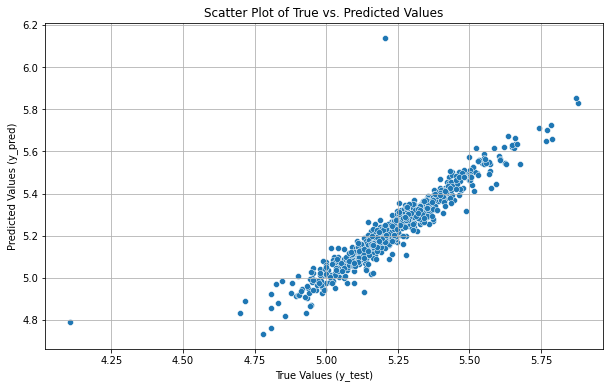

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have your y_pred and y_test as Pandas Series or DataFrames
# Example:
# y_pred = pd.Series([predicted values])
# y_test = pd.Series([true values])

# Create a DataFrame to store the predicted and true values
results_df = pd.DataFrame({'y_test': ytest, 'y_pred': ypred})

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='y_test', y='y_pred')
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Scatter Plot of True vs. Predicted Values')
plt.grid(True)
plt.show()